In [18]:
import fitsio
import numpy as np
import matplotlib.pyplot as plt
import json
from desitarget.targetmask import desi_mask
import glob
from collections import Counter
plt.rcParams.update({'font.size': 15})


In [76]:
program = "dark_gray"
program = "bright"
hemisphere = "north"
target_mask = desi_mask["BGS_ANY"]
targetdata = fitsio.read("targets/{}_{}.fits".format(program, hemisphere))
targetdata = np.sort(targetdata, order='TARGETID')

In [77]:
n = len(targetdata)
r = np.random.random(n)
rr = r < 0.001

In [78]:
fba_files = glob.glob("fba_{}_{}/fba-*.fits".format(program, hemisphere))
print(len(fba_files))

4143


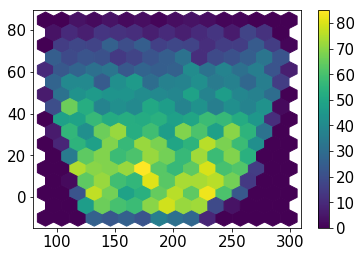

In [79]:
#plt.scatter(, , s=0.1)
plt.hexbin((targetdata['RA'][rr]), targetdata['DEC'][rr], gridsize=15,bins=None)
plt.colorbar()

In [ ]:
targetid_assigned = np.empty((0), dtype=np.int64)
targetid_available = np.empty((0), dtype=np.int64)
for fba_file in fba_files:
    fassign = fitsio.read(fba_file, ext="FASSIGN")
    favail = fitsio.read(fba_file, ext="FAVAIL")
    targetid_assigned = np.append(targetid_assigned, fassign["TARGETID"])
    targetid_available = np.append(targetid_available, favail["TARGETID"])

In [148]:
targetid_assigned

array([ 35186061017616778,  35186061017615887, 611646813321036004, ...,
        35186018361543053,  35186018361542391,  35186018361542515])

In [149]:
counter_assigned = Counter(targetid_assigned)

In [150]:
id_assigned = np.array(list(counter_assigned.keys()))
count_assigned = np.array(list(counter_assigned.values()))

ii = np.argsort(id_assigned)
id_assigned = id_assigned[ii]
count_assigned = count_assigned[ii]

is_target = np.isin(id_assigned, targetdata['TARGETID'])
id_assigned = id_assigned[is_target]
count_assigned = count_assigned[is_target]

n_assigned = np.zeros(len(targetdata), dtype=int)

ii = np.isin(targetdata['TARGETID'], id_assigned)
n_assigned[ii] = count_assigned

In [151]:
is_available = np.zeros(len(targetdata), dtype=bool)
id_available = np.isin(targetdata['TARGETID'], targetid_available)
is_available[id_available] = True

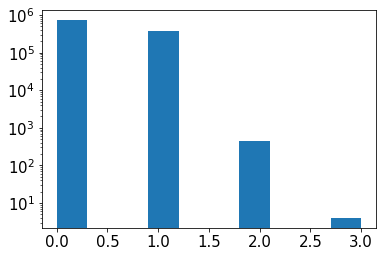

In [153]:
n = plt.hist(n_assigned[is_available], log=True)

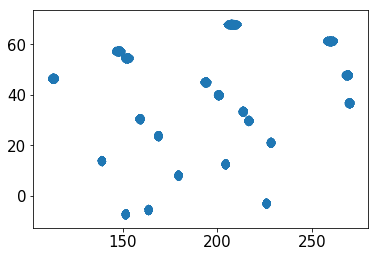

In [107]:
plt.scatter(targetdata['RA'][is_available], targetdata['DEC'][is_available], s=0.1)

In [91]:
len(targetid_available)

982595

In [104]:
np.count_nonzero(is_available)

114159

In [103]:
is_available

array([False, False, False, ..., False, False, False])

In [102]:
len(list(set(targetid_available)))

882920

In [125]:
a = list(counter_assigned.values())

In [126]:
b = list(counter_assigned.keys())

In [127]:
b

[35186061017616778,
 35186061017615887,
 611646813321036004,
 35186061017615143,
 35186061017615397,
 35186061017614099,
 35186061017614716,
 35186061017614688,
 35186061017613761,
 35186061017614047,
 35186061017613872,
 35186061017612737,
 611646813321035821,
 35186061017613069,
 35186061017613623,
 35186055112037382,
 611646807415456038,
 35186055112037858,
 35186061017612317,
 35186055112038122,
 35186055112037080,
 611646807415455966,
 35186055112037481,
 35186055112037370,
 35186055112037449,
 35186055112035619,
 35186055112035489,
 35186055112036073,
 35186055112036723,
 611646807415455992,
 611646807415455977,
 611646807415455871,
 35186055112034530,
 35186055112035173,
 35186055112035077,
 35186055112035737,
 35186055112035895,
 35186055112033925,
 35186055112033663,
 611646807415455840,
 611646807415455844,
 611646807415455863,
 611646807415455885,
 35186055112034978,
 35186055116227261,
 35186055112032882,
 35186055112032714,
 611646807415455841,
 611646807415455828,
 611646